In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import scale.olm.contrib as contrib
import scale.olm.core as core
from pathlib import Path
import scale.olm.complib as complib
import numpy as np
import matplotlib.pyplot as plt
import json
import os

In [2]:
scale_path = '/Applications/SCALE-7.0.pre-b7.app/Contents/Resources'

In [3]:
file = Path('data/Beznau-1_M308_K7_BM5_sample_burnup.txt')
with open(file,'r') as input:
    time,burnup,burnup_std = contrib.parse_sfcompo_operating_history(input)

2023-09-17 13:05:55 [warning  ] The cumulative burnup decreased from 9719.0 to 0.0 which is impossible. Setting to 9719.0.
2023-09-17 13:05:55 [warning  ] The cumulative burnup decreased from 9719.0 to 0.0 which is impossible. Setting to 9719.0.
2023-09-17 13:05:55 [warning  ] The cumulative burnup decreased from 19515.0 to 0.0 which is impossible. Setting to 19515.0.
2023-09-17 13:05:55 [warning  ] The cumulative burnup decreased from 19515.0 to 0.0 which is impossible. Setting to 19515.0.
2023-09-17 13:05:55 [warning  ] The cumulative burnup decreased from 25834.0 to 0.0 which is impossible. Setting to 25834.0.
2023-09-17 13:05:55 [warning  ] The cumulative burnup decreased from 25834.0 to 0.0 which is impossible. Setting to 25834.0.
2023-09-17 13:05:55 [warning  ] The cumulative burnup decreased from 38658.0 to 0.0 which is impossible. Setting to 38658.0.
2023-09-17 13:05:55 [warning  ] The cumulative burnup decreased from 38658.0 to 0.0 which is impossible. Setting to 38658.0.
2023

In [4]:
bh = core.BurnupHistory(time,burnup)

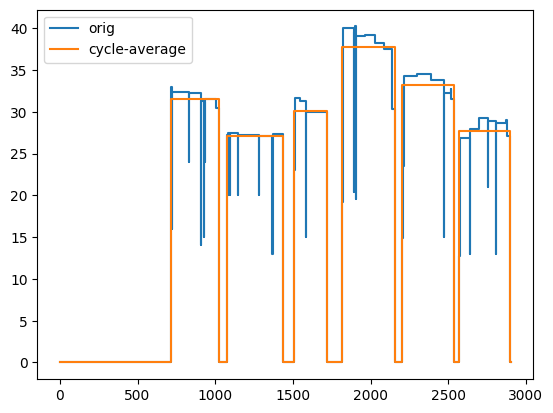

In [5]:
bh.plot_power_history(label='orig')
x = bh.classify_operations(min_shutdown_time=10.0)
new_time = bh.get_cycle_time(x)
bh2 = bh.regrid(new_time)
bh2.plot_power_history(label='cycle-average',add_to_existing=True)
burndata = []
fima_factor = 0.9432071293036596*0.9993793638545935
nd148_factor = 0.9549635163502574*0.9432071293036596*0.9993793638545935
power_factor = 1.0 #modify to calibrate calculation to match measured FIMA
for time,power in zip(bh2.interval_time,bh2.interval_power):
    burndata.append({"burn":time, "power":power*power_factor})

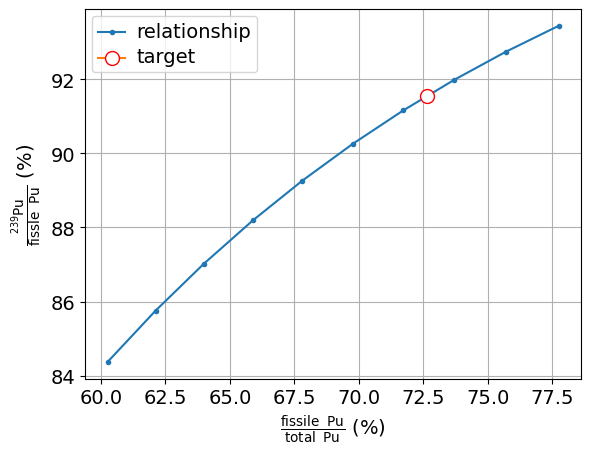

In [6]:
target_p=5.5
target_fp=72.64
x = contrib.sfcompo_guess_initial_mox(target_fp,target_p,plot=True)

In [7]:
tm=core.TemplateManager()
data={
    "_": {
        "env": {"work_dir": ""}, 
        "model": {"name": "mox_w14x14"}
    },
    "_arpinfo": {
        "interpvars": {
            "mod_dens": 0.75
        } 
    }, 
    "comp": {"system": x }, 
    "history": {
        "initialhm": 1, 
        "burndata": burndata
    }
}
contents = tm.expand('model/origami/system-mox.jt.inp',data)

In [8]:
# Remove the link for this use case.
def content_patch(contents):
    i=contents.find("=shell")
    e=contents.find('=origami')
    contents = contents.replace(contents[i:e],'')
    contents.replace('nlib=1','nlib=3')
    return contents
contents = content_patch(contents)
print(contents)

=origami

libs=[ mox_w14x14 ]

options{ ft71=all mtu=1 }

fuelcomp{
    stdcomp(c_uo2){ base=uo2 dens=10.4
        iso[
            92234=9.99999999998e-11
            92235=0.23099999999953796
            92236=9.99999999998e-11
            92238=99.76899999980047
        ]
    }
    stdcomp(c_puo2){ base=puo2 dens=10.4
        iso[
            94238=1.004872407301296
            94239=66.49989938874234
            94240=22.994586017532153
            94241=6.140090037926896
            94242=3.3605521484973133
        ]
    }
    stdcomp(c_am){ base=am  dens=10.4
        iso[
            95241=100.0
        ]
    }
    stdcomp(c_o2){ base=o  dens=10.4
    }
    mix(1){ comps[
        c_uo2 = 94.5000000000104
        c_puo2 = 5.499999999989605
        c_am = 4.8554667986940905e-22
        c_o2 = 6.445332012955142e-23
    ] }
}

modz = [ 0.75 ]
pz = [ 1.0 ]

hist[
  cycle{ power=0.0 burn=714.0 nlib=1 }
  cycle{ power=31.57569850552307 burn=307.79999999999995 nlib=1 }
  cycle{ power=0.0

In [9]:
td = core.TempDir()
path = td.write_file(contents,'origami.inp')
scalerte = scale_path + '/bin/scalerte'
sr = core.ScaleRunner(scalerte)

In [10]:
input,results = sr.run(path)
print(json.dumps(results,indent=4))

{
    "returncode": 0,
    "success": true,
    "errors": [],
    "command_line": "/Applications/SCALE-7.0.pre-b7.app/Contents/Resources/bin/scalerte ",
    "input_file": "/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpkavs5jq8/origami.inp",
    "output_file": "/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpkavs5jq8/origami.out",
    "message_file": "/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpkavs5jq8/origami.msg",
    "data_size": 124721543444,
    "scale_runtime_seconds": 6.459580183029175,
    "data_dir": "/Applications/SCALE-7.0.pre-b7.app/Contents/Resources/data",
    "scalerte_path": "/Applications/SCALE-7.0.pre-b7.app/Contents/Resources/bin/scalerte",
    "input_file_hash": "b30ce0f63f549d558dbe3cd1c33a5f50",
    "version": "7.0.pre-b7",
    "runtime_seconds": 6.460050106048584,
    "rerun": true
}


In [11]:
import scale.olm.internal as internal
f71 = Path(results['input_file']).with_suffix('.f71')
print(f71,f71.exists())

/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpkavs5jq8/origami.f71 True


In [12]:
def get_ii_json(f71):
    obiwan = scale_path + '/bin/obiwan'
    ii_json = internal.run_command(f"{obiwan} view -format=ii.json -cases='[1]' {f71}",echo=False)
    return json.loads(ii_json)

In [19]:
def parse_csv(path, delim=';'):
    lines = []
    with open(path, 'r') as f:
        for line in f:
            line = line.strip()
            lines.append(line.split(delim))

    return lines

measurements = parse_csv('data/Beznau-1_M308_K7_BM5_measurement.txt')
measurements = measurements[1:]
measured_fima = 0.0
total_u=0.0
total_pu=0.0
measured_mg_per_gUi = {}
measured_pct_unc = {}
for m in measurements:
    if m[2].startswith('Burnup %FIMA'):
        measured_fima = float(m[6])/100.
    if not m[1].startswith('Other'):
        nuclide = m[2].lower()
        conc = float(m[8])
        measured_mg_per_gUi[nuclide] = conc
        if nuclide.startswith('u'):
            total_u+=conc
        if nuclide.startswith('pu'):
            total_pu+=conc
        measured_pct_unc[nuclide] = float(m[10].replace('%',''))
print(measured_mg_per_gUi)
print('fima=',measured_fima)

{'u234': 0.05082, 'u235': 0.8383, 'u236': 0.304, 'u238': 905.2, 'np237': 0.1985, 'pu238': 0.9812, 'pu239': 10.49, 'pu240': 10.88, 'pu241': 5.071, 'pu242': 3.993, 'am241': 1.225, 'am242m': 0.0118, 'am243': 0.9801, 'cm244': 0.8497, 'cm245': 0.1036, 'cm246': 0.0169, 'ce144': 0.01407, 'nd142': 0.03233, 'nd143': 1.089, 'nd144': 1.656, 'nd145': 0.9166, 'nd146': 1.067, 'nd148': 0.616, 'nd150': 0.363, 'pm147': 0.07566, 'sm147': 0.2779, 'sm148': 0.329, 'sm149': 0.005842, 'sm150': 0.5343, 'sm151': 0.02768, 'sm152': 0.1997, 'sm154': 0.1202, 'eu151': 0.0008565, 'eu153': 0.2632, 'eu154': 0.06001, 'eu155': 0.01384, 'gd154': 0.03131, 'gd155': 0.009268, 'gd156': 0.2949, 'gd158': 0.06523, 'gd160': 0.004889, 'sr90': 0.456, 'mo95': 1.063, 'tc99': 1.214, 'ru101': 1.452, 'ru106': 0.2859, 'rh103': 1.214, 'ag109': 0.1236, 'sb125': 0.01001, 'i129': 0.1001, 'cs133': 1.792, 'cs134': 0.08236, 'cs135': 1.214, 'cs137': 1.962}
fima= 0.056299999999999996


In [20]:
base_ii = get_ii_json(f71)
base = core.InventoryInterface(base_ii)
ni_base = base.nuclide_inventory('case(1)')

2023-09-17 13:09:03 [info     ] Running external               command_line=/Applications/SCALE-7.0.pre-b7.app/Contents/Resources/bin/obiwan view -format=ii.json -cases='[1]' /var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpkavs5jq8/origami.f71


944962.678043956 grams of U initial


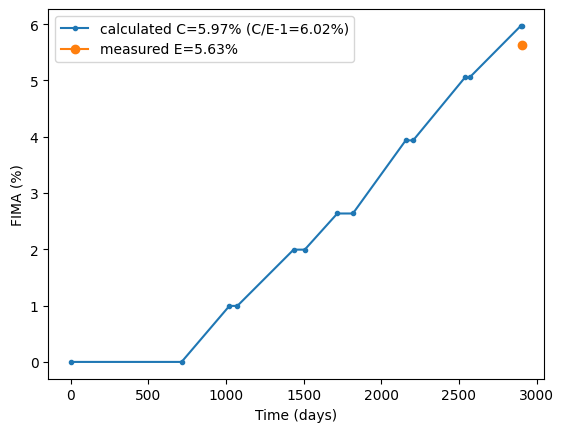

In [21]:
u_initial=0.0
cm = ni_base.composition_manager
for n,x in ni_base.nuclide_amount.items():
    eam = cm.eam(n)
    if eam.startswith('u'):
        u_initial+=x[0]*cm.mass(n)
scale = 1e3 / u_initial #mg/gUi
print(u_initial,'grams of U initial')
hm_mass = ni_base.get_hm_mass()
fima = 1.0-hm_mass/hm_mass[0]
plt.plot(ni_base.time/86400.,100*fima,label='calculated C={:.2f}% (C/E-1={:.2f}%)'.format(100*fima[-1],100*(fima[-1]/measured_fima-1)),marker='o',markersize=3)
plt.errorbar([ni_base.time[-1]/86400.],[100*measured_fima],marker='o',label='measured E={:.2f}%'.format(100*measured_fima))
plt.ylabel('FIMA (%)')
plt.xlabel('Time (days)')
plt.legend()
plt.show()

tc99    : calculated C=1.37e+00 g/gUi, measured E=1.21e+00 g/gUi +/- 5.51e-02 (4.54%), C/E-1=13.24%
cs134   : calculated C=2.48e-01 g/gUi, measured E=8.24e-02 g/gUi +/- 2.81e-03 (3.41%), C/E-1=200.56%
cs137   : calculated C=2.23e+00 g/gUi, measured E=1.96e+00 g/gUi +/- 5.98e-02 (3.05%), C/E-1=13.48%
nd148   : calculated C=6.85e-01 g/gUi, measured E=6.16e-01 g/gUi +/- 4.10e-02 (6.65%), C/E-1=11.15%
eu154   : calculated C=8.57e-02 g/gUi, measured E=6.00e-02 g/gUi +/- 1.51e-03 (2.52%), C/E-1=42.84%


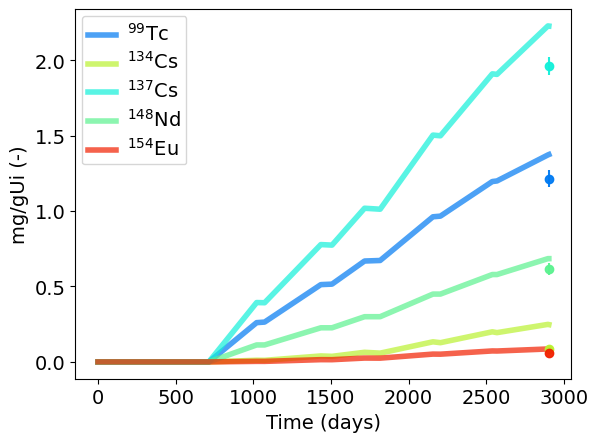

u234    : calculated C=2.97e-02 g/gUi, measured E=5.08e-02 g/gUi +/- 1.26e-02 (24.83%), C/E-1=-41.59%
u235    : calculated C=6.33e-01 g/gUi, measured E=8.38e-01 g/gUi +/- 1.48e-01 (17.68%), C/E-1=-24.51%
u236    : calculated C=3.17e-01 g/gUi, measured E=3.04e-01 g/gUi +/- 3.24e-02 (10.67%), C/E-1=4.30%


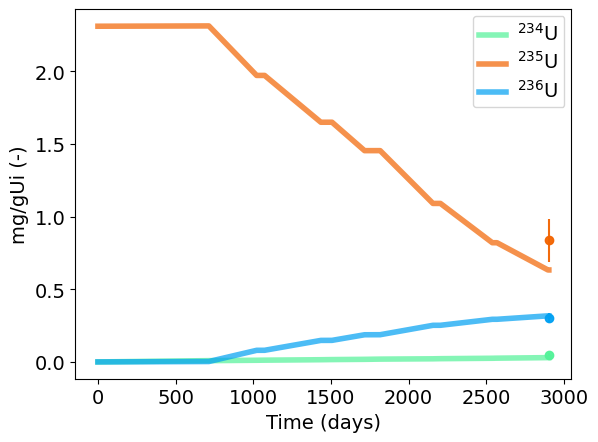

cm244   : calculated C=1.03e+00 g/gUi, measured E=8.50e-01 g/gUi +/- 3.48e-02 (4.09%), C/E-1=21.63%
am241   : calculated C=5.16e-01 g/gUi, measured E=1.23e+00 g/gUi +/- 5.68e-02 (4.64%), C/E-1=-57.91%
am242m  : calculated C=1.01e-02 g/gUi, measured E=1.18e-02 g/gUi +/- 6.29e-04 (5.33%), C/E-1=-14.42%
am243   : calculated C=1.32e+00 g/gUi, measured E=9.80e-01 g/gUi +/- 4.72e-02 (4.82%), C/E-1=34.26%


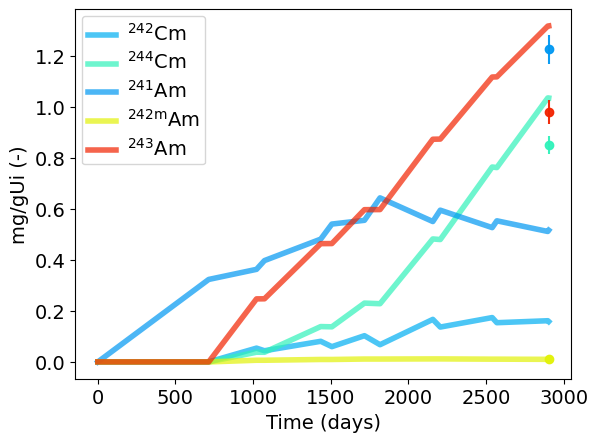

pu238   : calculated C=1.12e+00 g/gUi, measured E=9.81e-01 g/gUi +/- 1.17e-01 (11.89%), C/E-1=14.25%
pu239   : calculated C=1.07e+01 g/gUi, measured E=1.05e+01 g/gUi +/- 9.44e-02 (0.90%), C/E-1=2.31%
pu240   : calculated C=1.08e+01 g/gUi, measured E=1.09e+01 g/gUi +/- 1.08e-01 (0.99%), C/E-1=-0.88%
pu241   : calculated C=6.19e+00 g/gUi, measured E=5.07e+00 g/gUi +/- 5.38e-02 (1.06%), C/E-1=22.09%
pu242   : calculated C=4.85e+00 g/gUi, measured E=3.99e+00 g/gUi +/- 5.03e-02 (1.26%), C/E-1=21.37%


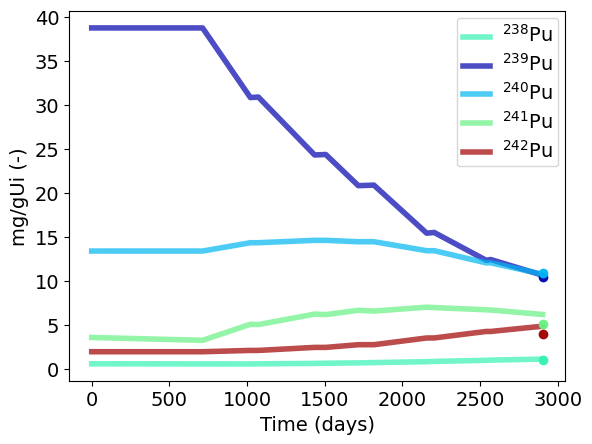

In [22]:
# Now we have all data loaded into memory.
# Let's make some plots.
nuclide_sets = []
nuclide_sets.append( ['tc99', 'cs134','cs137','nd148','eu154'] )
nuclide_sets.append( ['u234','u235','u236'] )
nuclide_sets.append( ['cm242','cm244','am241','am242m','am243'] )
nuclide_sets.append( ['pu238','pu239','pu240','pu241','pu242'] )
amount_map = {}
for nuclide_list in nuclide_sets:
    amount_map.update( ni_base.plot_nuclide_amounts(nuclide_list,amount_mult=scale,linewidth=4,alpha=0.7) )
    plt.ylabel('mg/gUi (-)')
    contrib.change_plot_font_size(plt.gca(),14)
    for nuclide in nuclide_list:
        if nuclide in measured_mg_per_gUi:
            t=ni_base.time[-1]/86400.
            e=float(measured_mg_per_gUi[nuclide])
            c = amount_map[nuclide][-1]
            relunc_e = float(measured_pct_unc[nuclide])/100.
            unc_e = relunc_e*e
            err = (c/e-1.0)
            print("{:8s}: calculated C={:.2e} g/gUi, measured E={:.2e} g/gUi +/- {:.2e} ({:.2f}%), C/E-1={:.2f}%".format(nuclide,c,e,unc_e,100*relunc_e,100*err))
            plt.errorbar([t],[e], yerr=unc_e, fmt='o', color=ni_base._nuclide_color(cm.izzzaaa(nuclide)))
    plt.show()

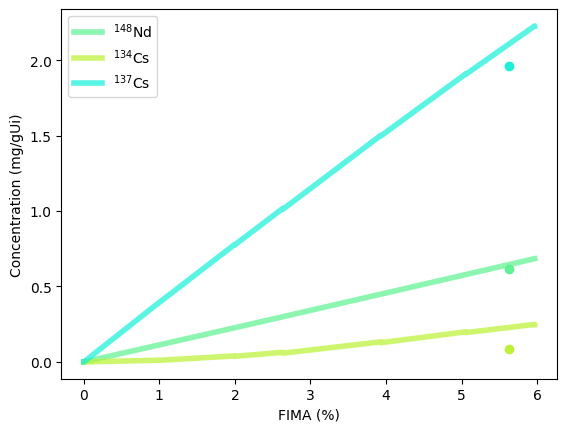

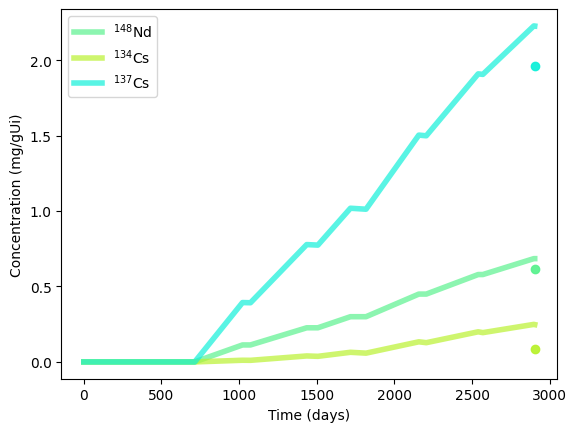

power correction to calibrate to measured FIMA: power_factor= 0.9432071293036596
power correction to calibrate to measured Nd-148: power_factor= 0.8996791045493993


In [29]:
for nuclide in ['nd148','cs134','cs137']:
    color = ni_base._nuclide_color(cm.izzzaaa(nuclide))
    plt.plot(100*fima,amount_map[nuclide],label=ni_base._nice_label(nuclide), color=color,linewidth=4,alpha=0.7)
    if nuclide in measured_mg_per_gUi:
        plt.errorbar(100*measured_fima,float(measured_mg_per_gUi[nuclide]),marker='o', color=color)
plt.legend()
plt.xlabel('FIMA (%)')
plt.ylabel('Concentration (mg/gUi)')
plt.show()

for nuclide in ['nd148','cs134','cs137']:
    color = ni_base._nuclide_color(cm.izzzaaa(nuclide))
    plt.plot(ni_base.time/86400.,amount_map[nuclide],label=ni_base._nice_label(nuclide), color=color,linewidth=4,alpha=0.7)
    if nuclide in measured_mg_per_gUi:
        plt.errorbar(ni_base.time[-1]/86400.,float(measured_mg_per_gUi[nuclide]),marker='o', color=color)
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Concentration (mg/gUi)')
plt.show()
print('power correction to calibrate to measured FIMA: power_factor=',measured_fima/fima[-1])
print('power correction to calibrate to measured Nd-148: power_factor=',measured_mg_per_gUi['nd148']/amount_map['nd148'][-1])

In [30]:
import copy
time = [0]
time.extend( np.cumsum(bh2.interval_time) )
power_uncertainty = 0.10
power_perts = np.random.uniform(1.0-power_uncertainty,1.0+power_uncertainty,size=10000)
i=0
bh_list = []
nreal = 100
print('generating',nreal,'realizations')
for j in range(nreal):
    power = copy.deepcopy(bh2.interval_power)
    for k in range(len(power)):
        power[k]*=power_perts[i]
        i+=1
    burnup = [0]
    burnup.extend( np.cumsum(power*np.asarray(bh2.interval_time)) )
    bh_list.append( core.BurnupHistory(time,burnup) )

generating 100 realizations


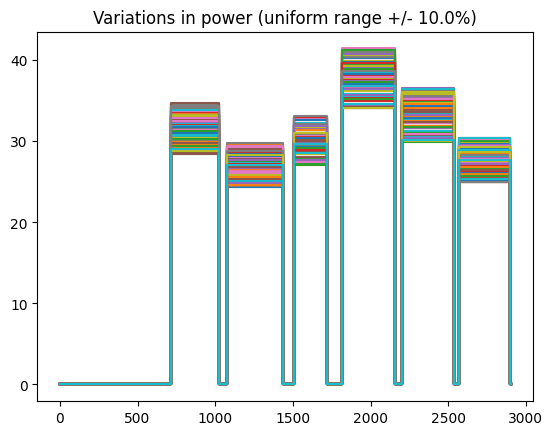

In [31]:
j=0
for bh in bh_list:
    bh.plot_power_history(label=str(j+1),add_to_existing=j!=0)
    j+=1
plt.title("Variations in power (uniform range +/- {:.1f}%)".format(100*power_uncertainty))
plt.gca().get_legend().remove()
plt.show()

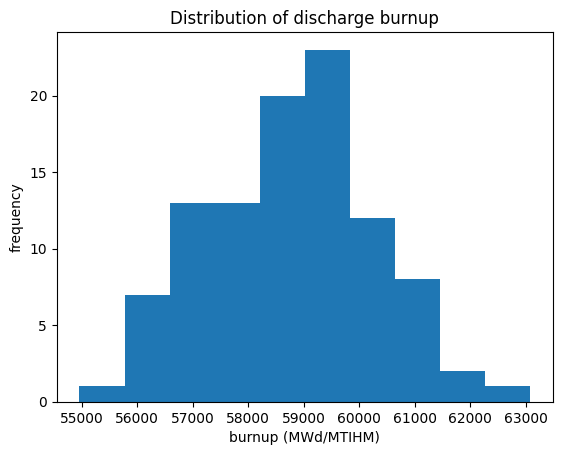

In [32]:
discharge_burnup=[]
for bh in bh_list:
    discharge_burnup.append( bh.burnup[-1] )
    j+=1
plt.hist(discharge_burnup)
plt.xlabel('burnup (MWd/MTIHM)')
plt.ylabel('frequency')
plt.title('Distribution of discharge burnup')
plt.show()

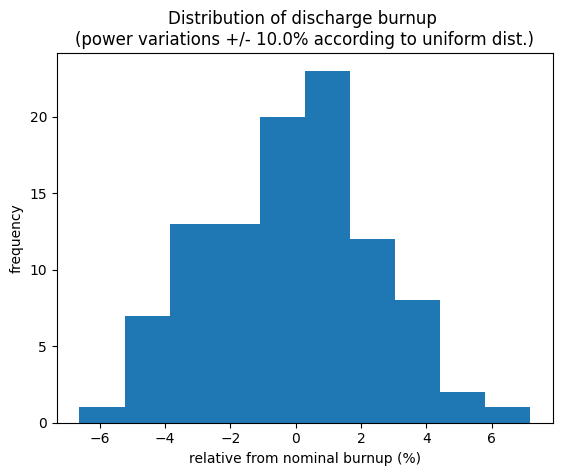

In [33]:
plt.hist(100*(discharge_burnup/bh2.burnup[-1] - 1))
plt.xlabel('relative from nominal burnup (%)')
plt.ylabel('frequency')
plt.title("Distribution of discharge burnup \n(power variations +/- {:.1f}% according to uniform dist.)".format(100*power_uncertainty))
plt.show()
# Note that sum of uniform distributions is 
# an Irwin-Hall distribution: https://en.wikipedia.org/wiki/Irwin%E2%80%93Hall_distribution

In [34]:
# Create all the inputs.
j=0
input_list=[]
for bh in bh_list:
    j+=1
    burndata = []
    for time,power in zip(bh.interval_time,bh.interval_power):
        burndata.append({"burn":time, "power":power})
    data['history']['burndata'] = burndata
    contents = tm.expand('model/origami/system-mox.jt.inp',data)
    path = td.write_file(contents,"origami{:03d}.inp".format(j))
    input_list.append(path)

In [35]:
# Create a thread executor.
num_workers=6
tpe = core.ThreadPoolExecutor(max_workers=num_workers)

In [36]:
results = tpe.execute(sr.run,input_list)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.29s/it]


In [37]:
for r in results:
    print(r)

/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpkavs5jq8/origami004.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpkavs5jq8/origami005.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpkavs5jq8/origami001.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpkavs5jq8/origami002.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpkavs5jq8/origami006.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpkavs5jq8/origami003.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpkavs5jq8/origami007.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpkavs5jq8/origami009.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpkavs5jq8/origami012.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpkavs5jq8/origami011.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpkavs5jq8/origami008.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpkavs5jq8/origami010.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpkavs5jq8/origami015.inp
/var/folders

In [38]:
f71_list = []
for r in results:
    f71_list.append( Path(results[r]['input_file']).with_suffix('.f71') )

In [39]:
def ii_json_runner(input_f71):
    return input_f71, get_ii_json(input_f71)
results_ii = tpe.execute(ii_json_runner,f71_list)

  0%|                                                                                                                                                             | 0/100 [00:00<?, ?it/s]2023-09-17 13:11:50 [info     ] Running external               command_line=/Applications/SCALE-7.0.pre-b7.app/Contents/Resources/bin/obiwan view -format=ii.json -cases='[1]' /var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpkavs5jq8/origami004.f71
2023-09-17 13:11:50 [info     ] Running external               command_line=/Applications/SCALE-7.0.pre-b7.app/Contents/Resources/bin/obiwan view -format=ii.json -cases='[1]' /var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpkavs5jq8/origami005.f71
2023-09-17 13:11:50 [info     ] Running external               command_line=/Applications/SCALE-7.0.pre-b7.app/Contents/Resources/bin/obiwan view -format=ii.json -cases='[1]' /var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpkavs5jq8/origami001.f71
2023-09-17 13:11:50 [info     ] Running external             

In [40]:
xx=dict()
for k,v in results_ii.items():
    xx[k.stem] = core.InventoryInterface(v).nuclide_inventory('case(1)') 

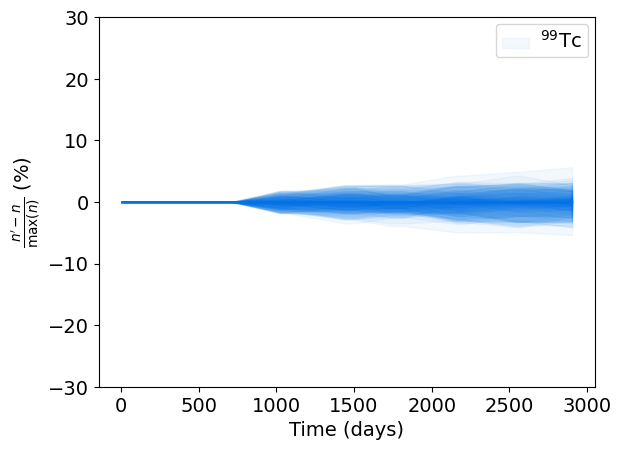

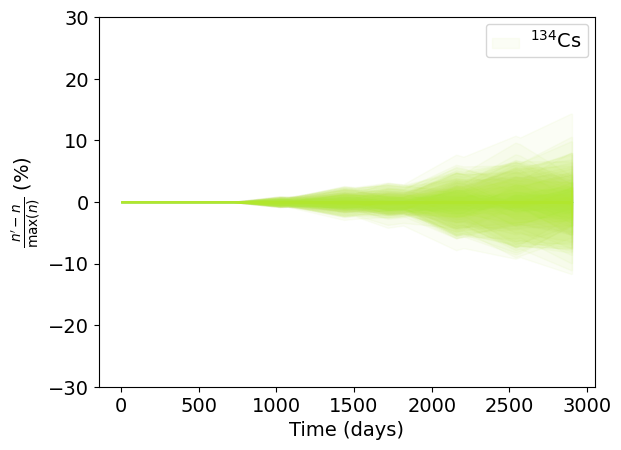

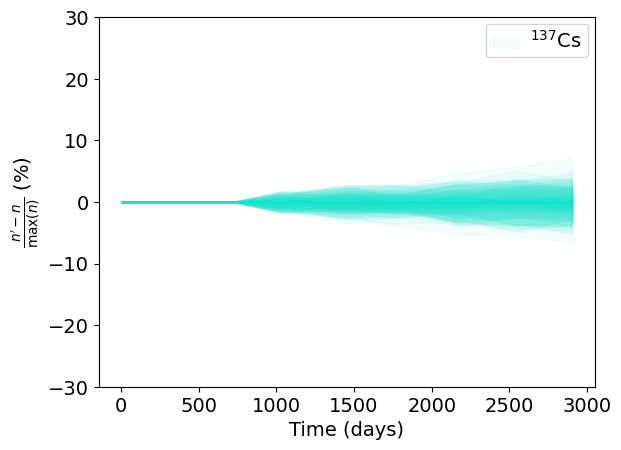

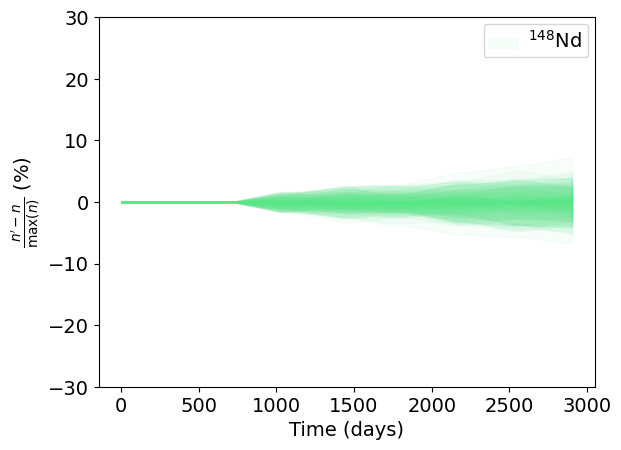

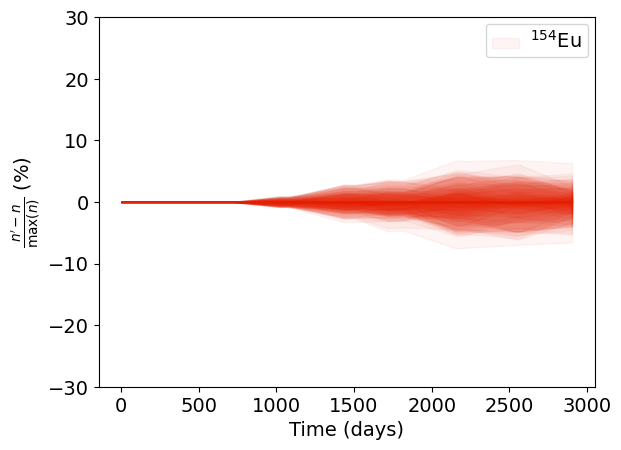

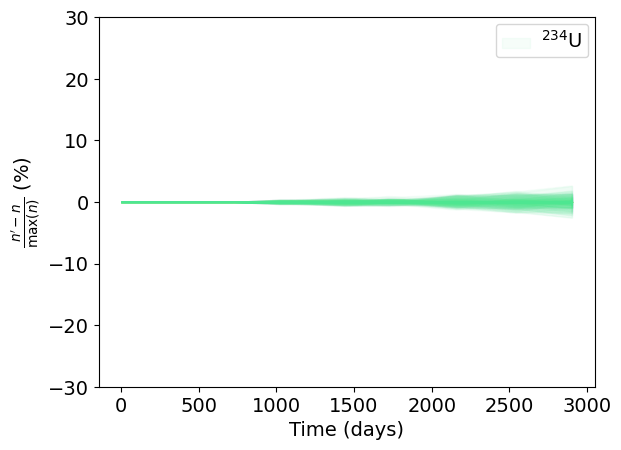

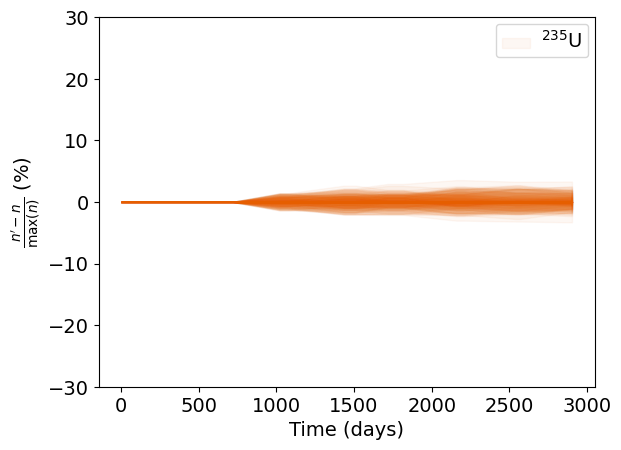

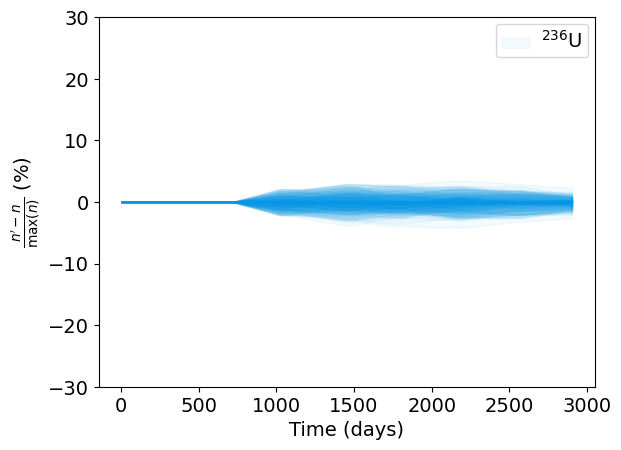

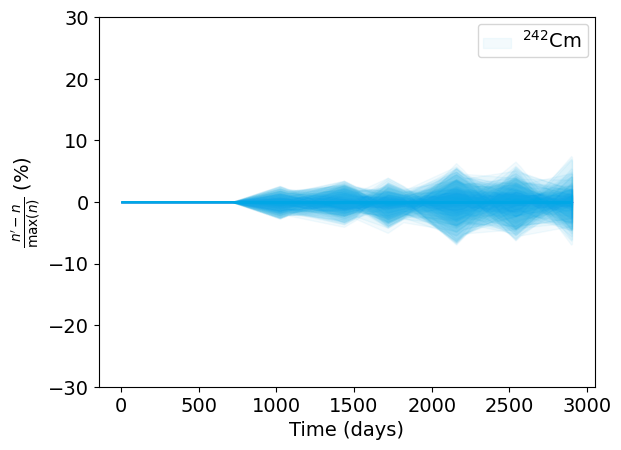

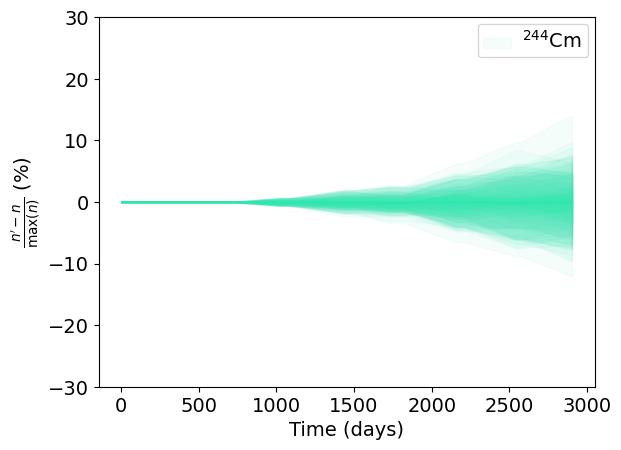

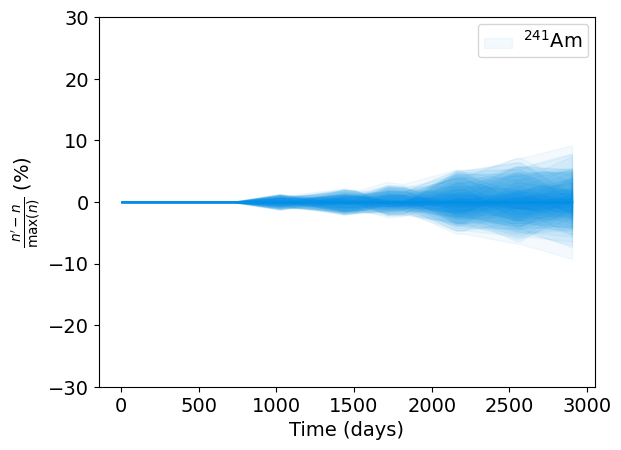

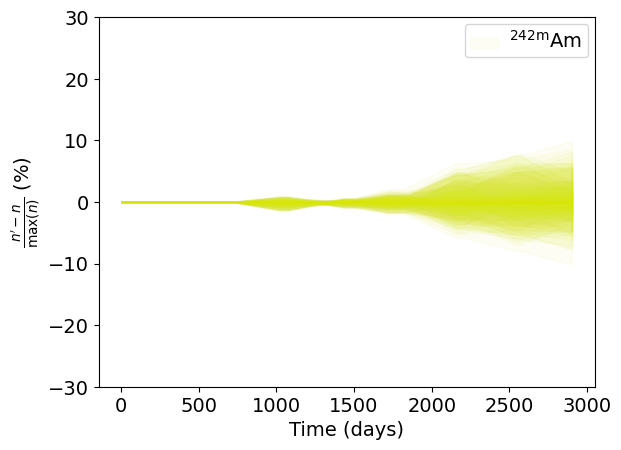

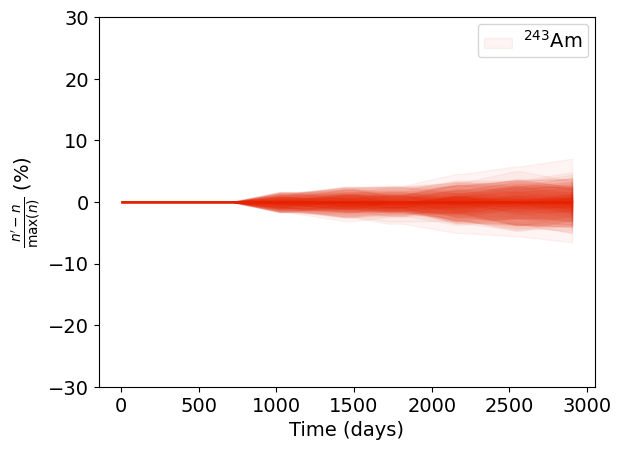

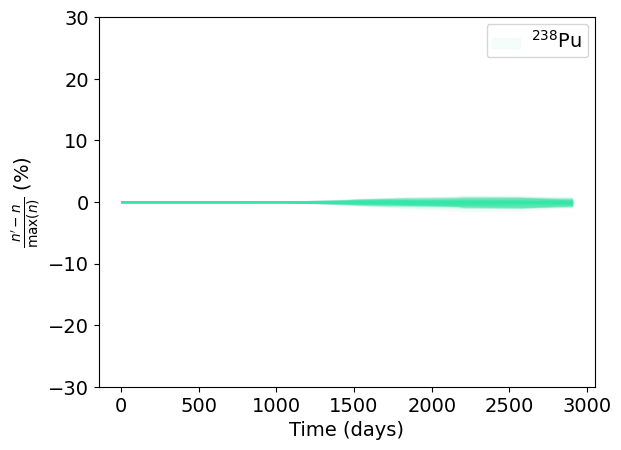

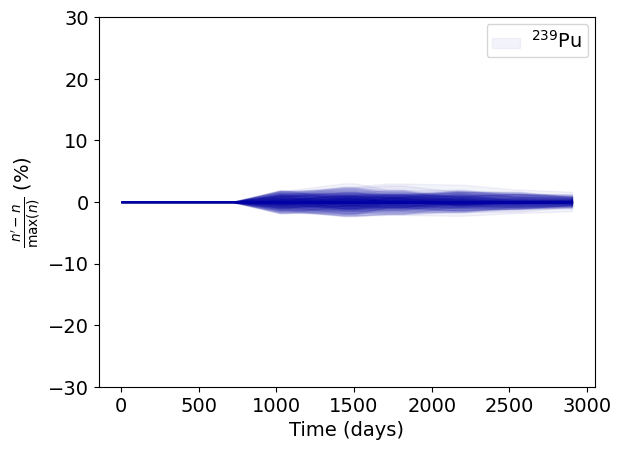

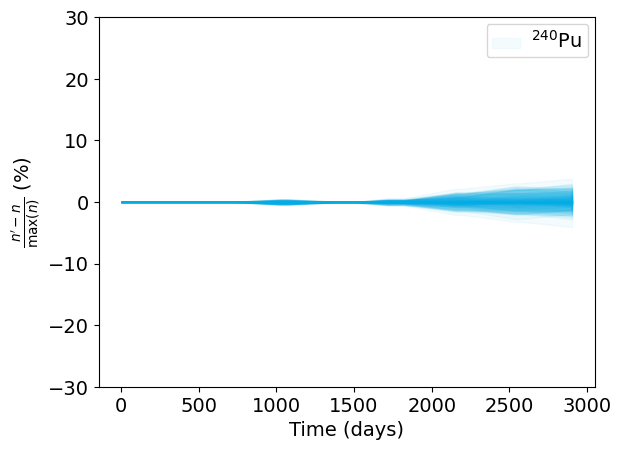

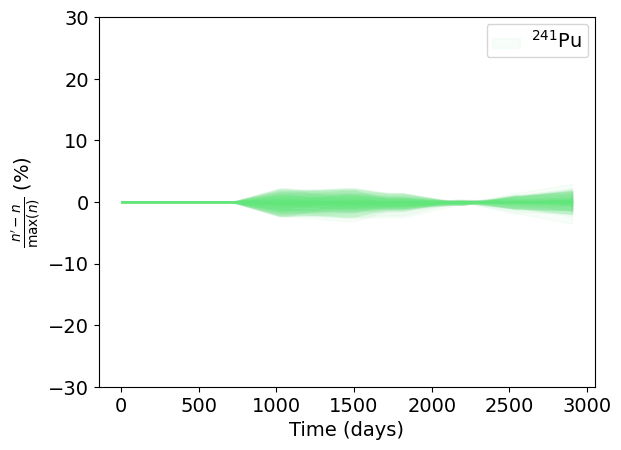

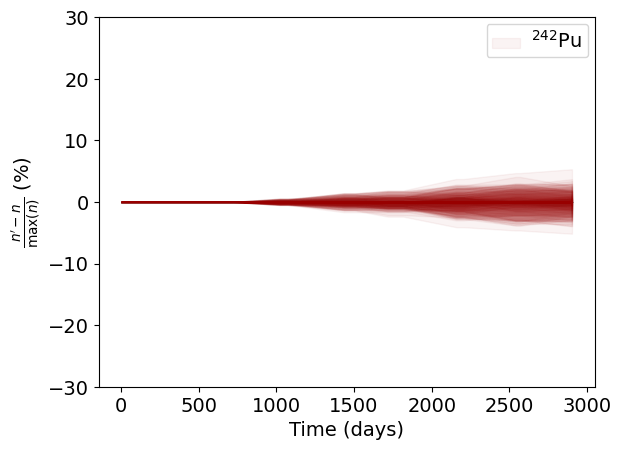

In [41]:
for nuclide_list in nuclide_sets:
    for nuclide in nuclide_list:
        for k,v in xx.items():
            color0=core.NuclideInventory._nuclide_color(ni_base.composition_manager.izzzaaa(nuclide))
            plt.fill_between(ni_base.time/86400.,
                     100*v.wrel_diff(nuclide,ni_base.get_amount(nuclide)), alpha=1/(1+0.2*len(xx)),
                     color=np.asarray(color0)*0.95 )
        plt.ylim([-300*power_uncertainty,300*power_uncertainty])
        plt.xlabel("Time (days)")
        plt.ylabel(r"$\frac{n'-n}{\mathrm{max}(n)}$ (%)")
        plt.legend([ni_base._nice_label(nuclide)])
        contrib.change_plot_font_size(plt.gca(),14)
        plt.show()